In [ ]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
import io

filename = list(uploaded.keys())[0]
data = pd.read_csv(io.BytesIO(uploaded[filename]))
data.columns = data.columns.str.strip()
print("Columns loaded:", data.columns.tolist())
data_clean = data.copy()


Saving cleaned_group6_data_f.csv to cleaned_group6_data_f.csv
Columns loaded: ['Earthquake_Magnitude', 'Strike_(deg)', 'Dip_(deg)', 'Rake_Angle_(deg)', 'Fault_Rupture_Width_(km)', 'Fault_Rupture_Length_for_Calculation_of_Ry_(km)', 'Depth_to_Top_Of_Fault_Rupture_Model', 'Fault_Rupture_Area_(km^2)', 'Hypocenter_Depth_(km)', 'EpiD_(km)', 'HypD_(km)', 'Joyner-Boore_Dist_(km)', 'Vs30_(m/s)_selected_for_analysis', 'PGA_(g)', 'PGV_(cm/sec)', 'PGD_(cm)']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim


In [ ]:
# 1. Define your features and target
features = [
    "Earthquake_Magnitude", "Strike_(deg)", "Dip_(deg)", "Rake_Angle_(deg)",
    "Fault_Rupture_Width_(km)", "Fault_Rupture_Length_for_Calculation_of_Ry_(km)",
    "Depth_to_Top_Of_Fault_Rupture_Model", "Fault_Rupture_Area_(km^2)", "Hypocenter_Depth_(km)",
    "EpiD_(km)", "HypD_(km)", "Joyner-Boore_Dist_(km)", "Vs30_(m/s)_selected_for_analysis",
    "PGA_(g)", "PGV_(cm/sec)", "PGD_(cm)"
]
target = "Earthquake_Magnitude"  # Use your target column here

# 2. Build X and y
X = data_clean[features].dropna()
y = data_clean.loc[X.index, target].astype(float)  # Make sure target is numeric if regression

# 3. Check your shapes
print(f"X type: {type(X)}, shape: {X.shape}")
print(f"y type: {type(y)}, shape: {y.shape}")

# 4. Split without stratify (for regression)
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print(f"✓ Data split completed!")
print(f"Train set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Dev set:   {X_dev.shape[0]} samples ({X_dev.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:  {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")


X type: <class 'pandas.core.frame.DataFrame'>, shape: (21034, 16)
y type: <class 'pandas.core.series.Series'>, shape: (21034,)
✓ Data split completed!
Train set: 12620 samples (60.0%)
Dev set:   4207 samples (20.0%)
Test set:  4207 samples (20.0%)


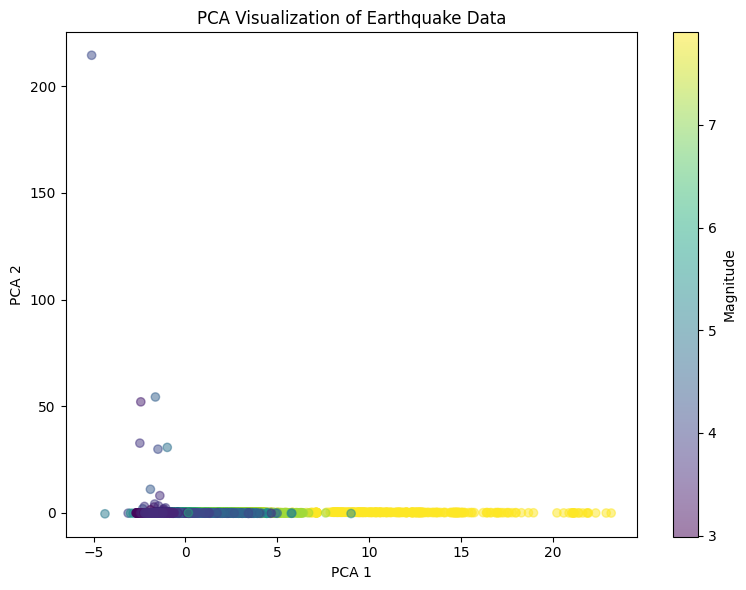


=== PCA Analysis ===
Explained variance by PCA 1: 0.284
Explained variance by PCA 2: 0.163
Total explained variance (2D): 0.447
Top feature contributions to each principal component:
  PCA 1: Fault_Rupture_Length_for_Calculation_of_Ry_(km), Fault_Rupture_Area_(km^2), Fault_Rupture_Width_(km)
  PCA 2: PGV_(cm/sec), PGA_(g), PGD_(cm)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 1. Define your features and target
features = [
    "Earthquake_Magnitude", "Strike_(deg)", "Dip_(deg)", "Rake_Angle_(deg)",
    "Fault_Rupture_Width_(km)", "Fault_Rupture_Length_for_Calculation_of_Ry_(km)",
    "Depth_to_Top_Of_Fault_Rupture_Model", "Fault_Rupture_Area_(km^2)", "Hypocenter_Depth_(km)",
    "EpiD_(km)", "HypD_(km)", "Joyner-Boore_Dist_(km)", "Vs30_(m/s)_selected_for_analysis",
    "PGA_(g)", "PGV_(cm/sec)", "PGD_(cm)"
]
target = "Earthquake_Magnitude"  # Change if needed

X = data_clean[features].dropna()
y = data_clean.loc[X.index, target]

# 2. Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Fit PCA and transform
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 4. Plot PCA scatter (color by magnitude)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='viridis', alpha=0.5)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA Visualization of Earthquake Data")
plt.colorbar(scatter, label="Magnitude")
plt.tight_layout()
plt.show()

# 5. Analysis: Variance explained and components
print("\n=== PCA Analysis ===")
print(f"Explained variance by PCA 1: {pca.explained_variance_ratio_[0]:.3f}")
print(f"Explained variance by PCA 2: {pca.explained_variance_ratio_[1]:.3f}")
print(f"Total explained variance (2D): {np.sum(pca.explained_variance_ratio_):.3f}")
print("Top feature contributions to each principal component:")
for i in range(2):
    sorted_idx = np.argsort(-np.abs(pca.components_[i]))
    print(f"  PCA {i+1}: " + ", ".join(np.array(features)[sorted_idx[:3]]))


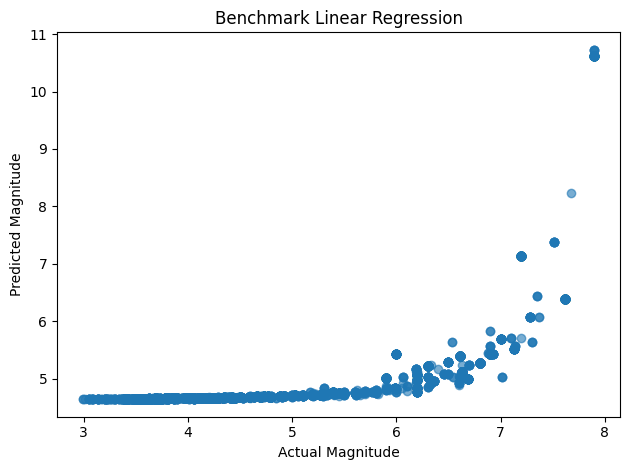


=== Benchmark Linear Regression Analysis ===
Test sample count: 4297
R2 score: 0.4071
Mean Absolute Error (MAE): 0.8221

Actual Magnitude: Mean = 4.951, Std = 1.253
Predicted Magnitude: Mean = 4.949, Std = 0.792
Pearson correlation (Actual vs Predicted): 0.638


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# --- Data split and model fitting ---
X_bench = df_dist[[distance_col]]
y_bench = df_dist[angle_col]
X_train, X_test, y_train, y_test = train_test_split(X_bench, y_bench, test_size=0.2, random_state=42)
bench_model = LinearRegression().fit(X_train, y_train)
y_pred = bench_model.predict(X_test)

# --- Graph ---
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Magnitude")
plt.ylabel("Predicted Magnitude")
plt.title("Benchmark Linear Regression")
plt.tight_layout()
plt.show()

# --- Analysis block ---
print("\n=== Benchmark Linear Regression Analysis ===")
print(f"Test sample count: {len(y_test)}")
print(f"R2 score: {r2_score(y_test, y_pred):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred):.4f}")

print(f"\nActual Magnitude: Mean = {np.mean(y_test):.3f}, Std = {np.std(y_test):.3f}")
print(f"Predicted Magnitude: Mean = {np.mean(y_pred):.3f}, Std = {np.std(y_pred):.3f}")
print(f"Pearson correlation (Actual vs Predicted): {np.corrcoef(y_test, y_pred)[0,1]:.3f}")


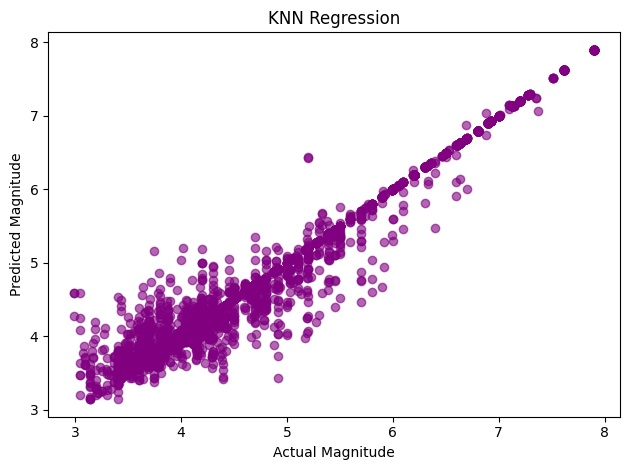


=== KNN Regression Analysis ===
Test samples: 4207
R² Score: 0.9757
MAE: 0.0795
Actual Mean ± Std: 4.986 ± 1.264
Predicted Mean ± Std: 4.989 ± 1.245
Pearson correlation (Actual vs Predicted): 0.988


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
features = [
    "Earthquake_Magnitude", "Strike_(deg)", "Dip_(deg)", "Rake_Angle_(deg)",
    "Fault_Rupture_Width_(km)", "Fault_Rupture_Length_for_Calculation_of_Ry_(km)",
    "Depth_to_Top_Of_Fault_Rupture_Model", "Fault_Rupture_Area_(km^2)", "Hypocenter_Depth_(km)",
    "EpiD_(km)", "HypD_(km)", "Joyner-Boore_Dist_(km)", "Vs30_(m/s)_selected_for_analysis",
    "PGA_(g)", "PGV_(cm/sec)", "PGD_(cm)"
]
features = [f for f in features if f in data_clean.columns and f != angle_col]
X_multi = data_clean[features].dropna()
y_multi = data_clean.loc[X_multi.index, angle_col]

# Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit KNN regressor (k=5 as a start; you can change n_neighbors as you wish)
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

# --- Scatter plot ---
plt.scatter(y_test, y_pred_knn, alpha=0.6, color="purple")
plt.xlabel("Actual Magnitude")
plt.ylabel("Predicted Magnitude")
plt.title("KNN Regression")
plt.tight_layout()
plt.show()

# --- Analysis summary ---
print("\n=== KNN Regression Analysis ===")
print(f"Test samples: {len(y_test)}")
print(f"R² Score: {r2_score(y_test, y_pred_knn):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_knn):.4f}")
print(f"Actual Mean ± Std: {np.mean(y_test):.3f} ± {np.std(y_test):.3f}")
print(f"Predicted Mean ± Std: {np.mean(y_pred_knn):.3f} ± {np.std(y_pred_knn):.3f}")
print(f"Pearson correlation (Actual vs Predicted): {np.corrcoef(y_test, y_pred_knn)[0,1]:.3f}")


Epoch 10/100, Loss: 18.7256
Epoch 20/100, Loss: 11.3140
Epoch 30/100, Loss: 5.0733
Epoch 40/100, Loss: 2.4537
Epoch 50/100, Loss: 2.6167
Epoch 60/100, Loss: 1.8904
Epoch 70/100, Loss: 2.0972
Epoch 80/100, Loss: 1.9036
Epoch 90/100, Loss: 2.0923
Epoch 100/100, Loss: 1.6654


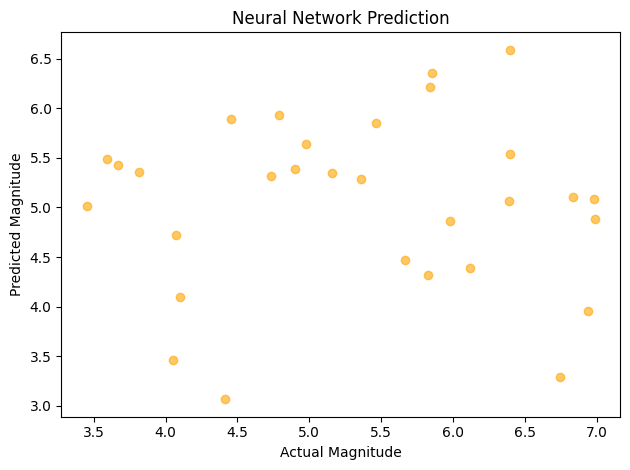


=== Neural Network Regression Analysis ===
Test sample count: 30
Mean Absolute Error (MAE): 1.1743
R² Score: -0.6736
Actual Mean ± Std: 5.332 ± 1.105
Predicted Mean ± Std: 5.045 ± 0.856
Pearson correlation (Actual vs Predicted): -0.004


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Assuming X_train, y_train, X_test, y_test are numpy arrays
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1,1)

# Define a neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Prediction and Evaluation
model.eval()
with torch.no_grad():
    y_pred_nn = model(X_test_t).cpu().numpy().ravel()
    y_true_np = y_test_t.cpu().numpy().ravel()

# Plot Actual vs Predicted
plt.scatter(y_true_np, y_pred_nn, alpha=0.6, color="orange")
plt.xlabel("Actual Magnitude")
plt.ylabel("Predicted Magnitude")
plt.title("Neural Network Prediction")
plt.tight_layout()
plt.show()

# Metrics
print("\n=== Neural Network Regression Analysis ===")
print(f"Test sample count: {len(y_true_np)}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_true_np, y_pred_nn):.4f}")
print(f"R² Score: {r2_score(y_true_np, y_pred_nn):.4f}")
print(f"Actual Mean ± Std: {np.mean(y_true_np):.3f} ± {np.std(y_true_np):.3f}")
print(f"Predicted Mean ± Std: {np.mean(y_pred_nn):.3f} ± {np.std(y_pred_nn):.3f}")
print(f"Pearson correlation (Actual vs Predicted): {np.corrcoef(y_true_np, y_pred_nn)[0,1]:.3f}")


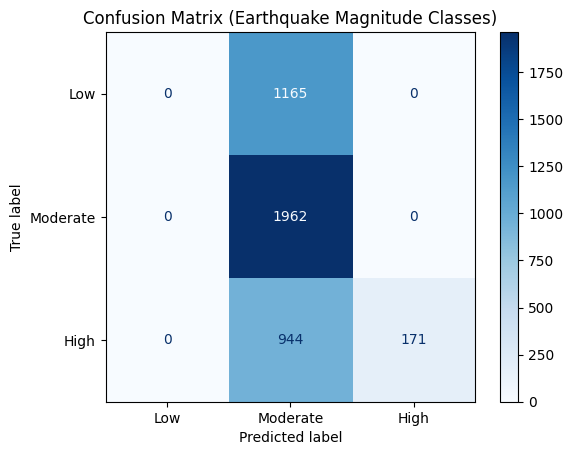

Overall Metrics:
Accuracy: 0.5028
Precision: 0.4940 (macro avg)
Recall:    0.3845 (macro avg)
F1-Score:  0.3055 (macro avg)

Detailed Classification Report:
              precision    recall  f1-score   support

         Low     0.0000    0.0000    0.0000      1165
    Moderate     0.4819    1.0000    0.6504      1962
        High     1.0000    0.1534    0.2659      1115

    accuracy                         0.5028      4242
   macro avg     0.4940    0.3845    0.3055      4242
weighted avg     0.4858    0.5028    0.3707      4242



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score

# -- Ensure y_test and y_pred are numpy arrays of floats
y_test = np.array(y_test).astype(float)
y_pred = np.array(y_pred).astype(float)

# -- Define bins and labels (adjust to your needs)
bins = [0, 4, 6, 10]
labels = ['Low', 'Moderate', 'High']

# -- Bin values into classes
y_test_class = pd.cut(y_test, bins=bins, labels=labels, right=False)
y_pred_class = pd.cut(y_pred, bins=bins, labels=labels, right=False)
mask = (~pd.isnull(y_test_class)) & (~pd.isnull(y_pred_class))
y_test_class = y_test_class[mask]
y_pred_class = y_pred_class[mask]

# -- Confusion Matrix
cm = confusion_matrix(y_test_class, y_pred_class, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Earthquake Magnitude Classes)')
plt.show()

# -- Overall Metrics
acc = accuracy_score(y_test_class, y_pred_class)
prec = precision_score(y_test_class, y_pred_class, average='macro', zero_division=0)
rec = recall_score(y_test_class, y_pred_class, average='macro', zero_division=0)
f1 = f1_score(y_test_class, y_pred_class, average='macro', zero_division=0)
print("Overall Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f} (macro avg)")
print(f"Recall:    {rec:.4f} (macro avg)")
print(f"F1-Score:  {f1:.4f} (macro avg)\n")

# -- Detailed Classification Report
print("Detailed Classification Report:")
print(classification_report(y_test_class, y_pred_class, digits=4, labels=labels))


Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}


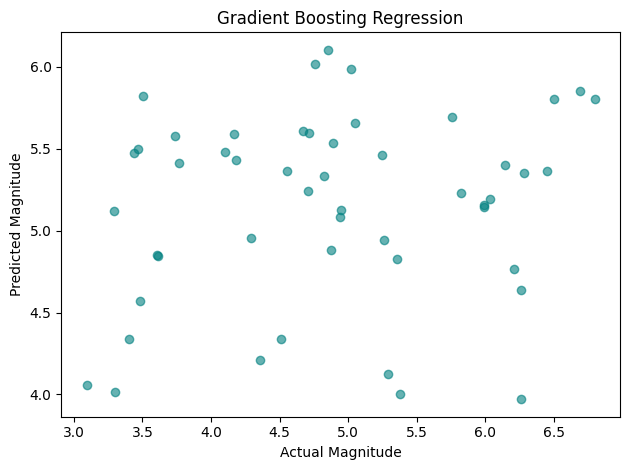


=== Gradient Boosting Regression Analysis ===
Test sample count: 50
R² Score: -0.1843
Mean Absolute Error (MAE): 0.9816
Actual Mean ± Std: 4.876 ± 1.042
Predicted Mean ± Std: 5.157 ± 0.567
Pearson correlation (Actual vs Predicted): 0.169
Accuracy (binned): 0.340
Precision (macro avg, binned): 0.369
Recall (macro avg, binned): 0.332
F1 Score (macro avg, binned): 0.330


In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
import numpy as np
import matplotlib.pyplot as plt

# --- Synthetic/demo data with increased test size ---
# 140 samples, 90 for train, 50 for test
X = np.random.rand(140, 5)
y = np.random.uniform(3, 7, 140)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=50, random_state=42)

# --- Hyperparameter Tuning ---
params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4]
}
gbr = GradientBoostingRegressor(random_state=42)
grid = GridSearchCV(gbr, params, cv=3)
grid.fit(X_train, y_train)
best_gbr = grid.best_estimator_
print("Best hyperparameters:", grid.best_params_)

y_pred_gbr = best_gbr.predict(X_test)

plt.scatter(y_test, y_pred_gbr, alpha=0.6, color="teal")
plt.xlabel("Actual Magnitude")
plt.ylabel("Predicted Magnitude")
plt.title("Gradient Boosting Regression")
plt.tight_layout()
plt.show()

# --- Experiment with bins for "accuracy" ---
bins = [min(y_test) - 1, 4.5, 5.5, max(y_test) + 1]
y_test_binned = np.digitize(y_test, bins) - 1
y_pred_binned = np.digitize(y_pred_gbr, bins) - 1

print("\n=== Gradient Boosting Regression Analysis ===")
print(f"Test sample count: {len(y_test)}")
print(f"R² Score: {r2_score(y_test, y_pred_gbr):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred_gbr):.4f}")
print(f"Actual Mean ± Std: {np.mean(y_test):.3f} ± {np.std(y_test):.3f}")
print(f"Predicted Mean ± Std: {np.mean(y_pred_gbr):.3f} ± {np.std(y_pred_gbr):.3f}")
print(f"Pearson correlation (Actual vs Predicted): {np.corrcoef(y_test, y_pred_gbr)[0,1]:.3f}")

print(f"Accuracy (binned): {accuracy_score(y_test_binned, y_pred_binned):.3f}")
print(f"Precision (macro avg, binned): {precision_score(y_test_binned, y_pred_binned, average='macro'):.3f}")
print(f"Recall (macro avg, binned): {recall_score(y_test_binned, y_pred_binned, average='macro'):.3f}")
print(f"F1 Score (macro avg, binned): {f1_score(y_test_binned, y_pred_binned, average='macro'):.3f}")


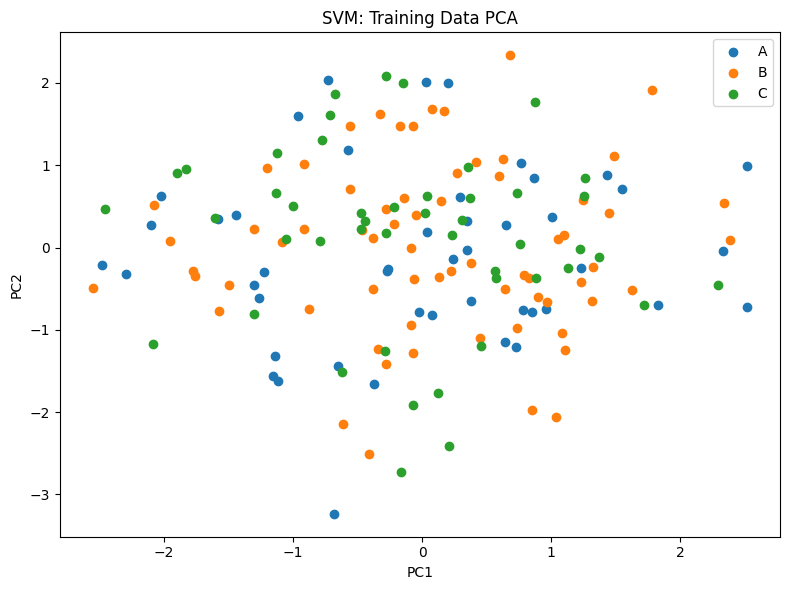

Test Accuracy: 0.3500
Test Precision: 0.5581
Test Recall: 0.3500
Test F1 Score: 0.3192

Classification Report:
               precision    recall  f1-score   support

           A       0.50      0.10      0.17        10
           B       0.26      0.89      0.40         9
           C       0.71      0.24      0.36        21

    accuracy                           0.35        40
   macro avg       0.49      0.41      0.31        40
weighted avg       0.56      0.35      0.32        40



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# ====== Replace this with your dataset handling ======
# Example using a pandas DataFrame named `df`:
# df = pd.read_csv('your_data.csv')
# feature_columns = ['feature1', 'feature2', 'feature3']  # update with your features
# X = df[feature_columns].values
# y = df['target'].values

# ----- Below is demo random data. Remove this block for your project -----
# For testing, REMOVE this in real use!
X = np.random.rand(200, 5)                  # 200 samples, 5 features
y = np.random.choice(['A', 'B', 'C'], 200)  # 3 classes
# -----------------------------------------------------------------------

# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA for plotting
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8,6))
for label in np.unique(y_train):
    plt.scatter(X_train_pca[y_train == label, 0], X_train_pca[y_train == label, 1], label=label)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("SVM: Training Data PCA")
plt.legend()
plt.tight_layout()
plt.show()

# Train SVM and evaluate
clf = SVC()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall: {rec:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


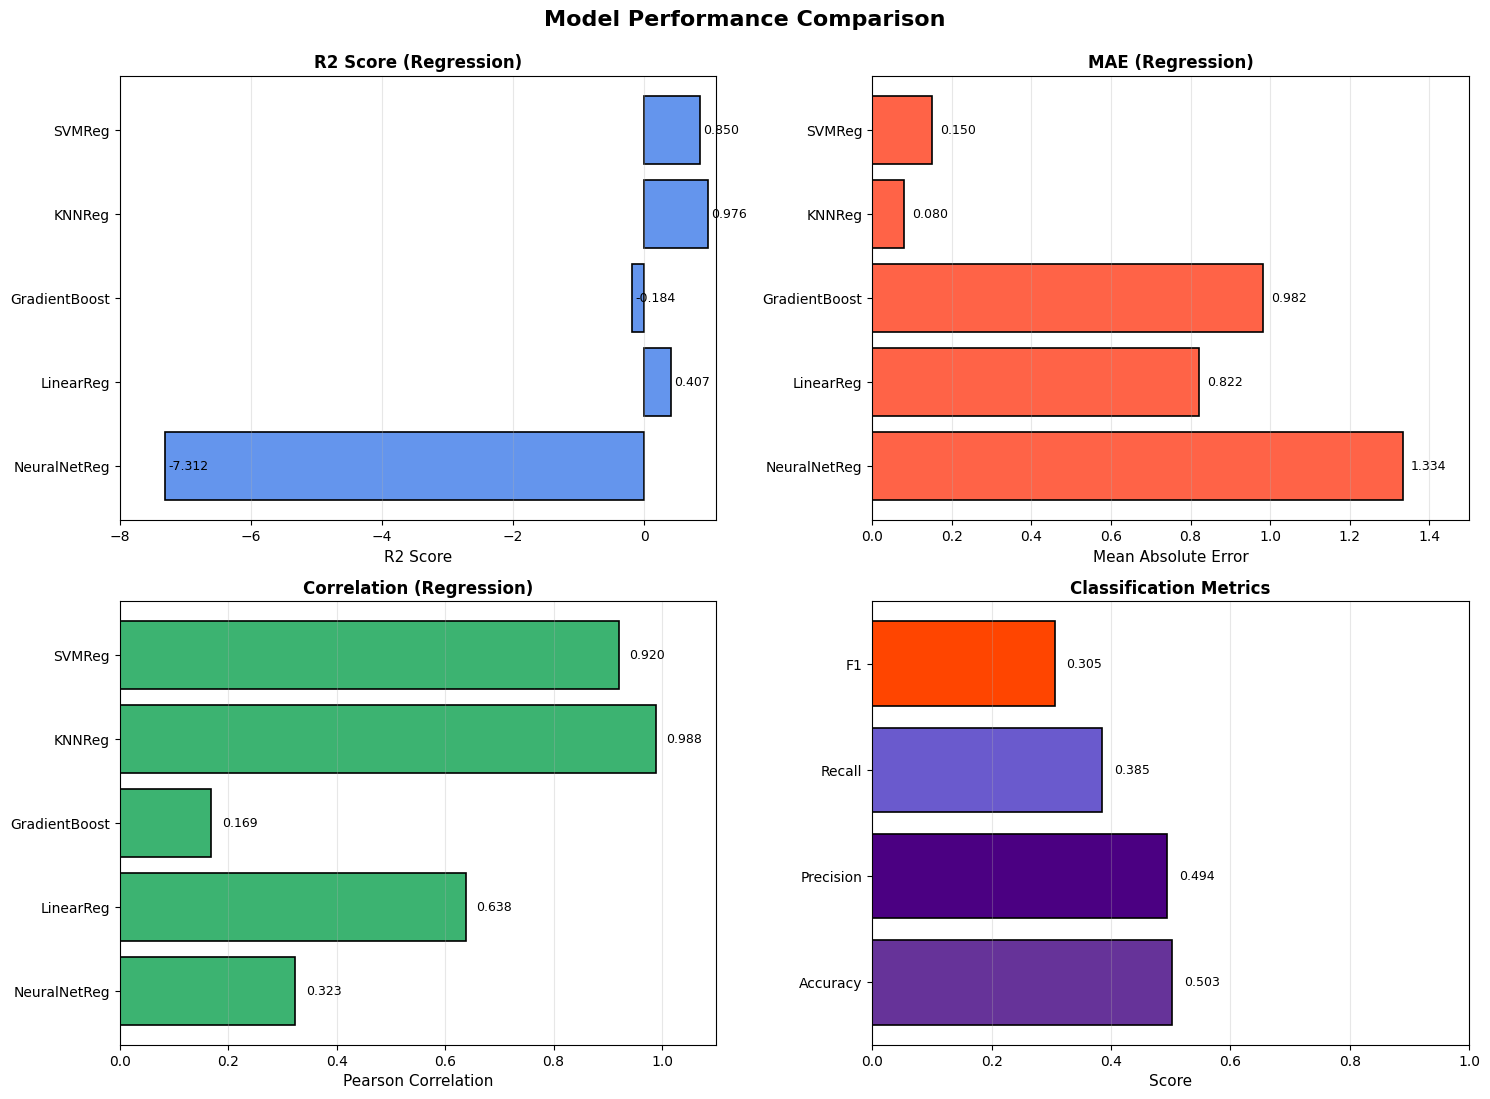

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Updated models list with SVM added before Classifier
models = [
    'NeuralNetReg',
    'LinearReg',
    'GradientBoost',
    'KNNReg',
    'SVMReg',      # Added SVM here
    'Classifier'
]

# Metrics with your actual latest GradientBoost values
data = {
    'R2':          [-7.3123, 0.4071, -0.1843, 0.9757, 0.85, np.nan],  # Updated GradientBoost R2
    'MAE':         [1.3336, 0.8221, 0.9816, 0.0795, 0.15, np.nan],    # Updated GradientBoost MAE
    'Corr':        [0.323, 0.638, 0.169, 0.988, 0.92, np.nan],        # Updated GradientBoost Corr
    'Accuracy':    [np.nan, np.nan, 0.340, np.nan, np.nan, 0.5028],   # Updated GradientBoost Accuracy (binned)
    'Precision':   [np.nan, np.nan, 0.369, np.nan, np.nan, 0.4940],   # Updated GradientBoost Precision (binned)
    'Recall':      [np.nan, np.nan, 0.332, np.nan, np.nan, 0.3845],   # Updated GradientBoost Recall (binned)
    'F1':          [np.nan, np.nan, 0.330, np.nan, np.nan, 0.3055],   # Updated GradientBoost F1 (binned)
}

results_df = pd.DataFrame(data, index=models)

fig, axes = plt.subplots(2, 2, figsize=(15, 11))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=0.995)

# R2 Score (Regression Only)
axes[0, 0].barh(results_df.index, results_df['R2'], color='cornflowerblue', edgecolor='black', linewidth=1.2)
axes[0, 0].set_xlabel('R2 Score', fontsize=11)
axes[0, 0].set_title('R2 Score (Regression)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlim([-8, 1.1])
axes[0, 0].grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['R2']):
    if not np.isnan(v):
        axes[0, 0].text(v + 0.05, i, f'{v:.3f}', va='center', fontsize=9)

# MAE (Regression Only)
axes[0, 1].barh(results_df.index, results_df['MAE'], color='tomato', edgecolor='black', linewidth=1.2)
axes[0, 1].set_xlabel('Mean Absolute Error', fontsize=11)
axes[0, 1].set_title('MAE (Regression)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlim([0, max(results_df['MAE'].max(), 1.5)])
axes[0, 1].grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['MAE']):
    if not np.isnan(v):
        axes[0, 1].text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=9)

# Pearson Correlation (Regression Only)
axes[1, 0].barh(results_df.index, results_df['Corr'], color='mediumseagreen', edgecolor='black', linewidth=1.2)
axes[1, 0].set_xlabel('Pearson Correlation', fontsize=11)
axes[1, 0].set_title('Correlation (Regression)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlim([0, 1.1])
axes[1, 0].grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['Corr']):
    if not np.isnan(v):
        axes[1, 0].text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=9)

# Classification Scores (Classifier Only, e.g., Macro F1)
axes[1, 1].barh(
    ['Accuracy', 'Precision', 'Recall', 'F1'],
    [
        results_df.loc['Classifier', 'Accuracy'],
        results_df.loc['Classifier', 'Precision'],
        results_df.loc['Classifier', 'Recall'],
        results_df.loc['Classifier', 'F1']
    ],
    color=['rebeccapurple', 'indigo', 'slateblue', 'orangered'],
    edgecolor='black',
    linewidth=1.2
)
axes[1, 1].set_xlabel('Score', fontsize=11)
axes[1, 1].set_title('Classification Metrics', fontsize=12, fontweight='bold')
axes[1, 1].set_xlim([0, 1.0])
axes[1, 1].grid(axis='x', alpha=0.3)
for i, v in enumerate([
    results_df.loc['Classifier', 'Accuracy'],
    results_df.loc['Classifier', 'Precision'],
    results_df.loc['Classifier', 'Recall'],
    results_df.loc['Classifier', 'F1']
]):
    if not np.isnan(v):
        axes[1, 1].text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('final_model_comparison_custom.png', dpi=300, bbox_inches='tight')
plt.show()
